<a href="https://colab.research.google.com/github/NavedAFZ/RNN/blob/master/classifying_name.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip "/content/data (2).zip" -d "/content/data.zip"

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os


import unicodedata
import string

In [0]:
def findFiles(path): return glob.glob(path)



#Preparing DATA

In [0]:
print(findFiles('/content/data.zip/data/names/*.txt'))


In [0]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [0]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [0]:
print(unicodeToAscii('Ślusàrski'))

In [0]:
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/content/data.zip/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [0]:
all_categories

In [0]:
category_lines

#Converting letters to tensors

In [0]:
import torch

In [0]:
def letterToIndex(letter):
  return all_letters.find(letter)

In [0]:
letterToIndex('J')

In [0]:
def letterTOTensor(letter):
  a1=torch.zeros(1,len(all_letters))
  a1[0][letterToIndex(letter)]=1
  return a1

In [0]:
letterTOTensor('j')

In [0]:
def lineToTensor(line):
  a1=torch.zeros(len(line),1,len(all_letters))
  for index,letter in enumerate(line):
    a1[index][0][letterToIndex(letter)]=1
  return a1  

In [24]:
lineToTensor('Hello').size()

torch.Size([5, 1, 57])

In [0]:
lineToTensor('Hello')

#Model

# Manually coded

In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size=hidden_size
        self.iOh=nn.Linear(input_size+hidden_size,hidden_size)
        self.iOo=nn.Linear(input_size+hidden_size,output_size)
        self.softmax=nn.LogSoftmax(dim=1)
    def forward(self,input,hidden):
      combined=torch.cat((input,hidden),1)
      hidden=self.iOh(combined)
      output=self.iOo(combined)
      output=self.softmax(output)
      return output,hidden
    def initHidden(self):
      h1=torch.zeros(1,self.hidden_size)
      return h1  



#Using inbuilt Rnn module

In [140]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()
        self.hidden_size=hidden_size
        self.rnn1=nn.RNN(input_size,hidden_size)
        #self.iOh=nn.Linear(input_size+hidden_size,hidden_size)
        self.iOo=nn.Linear(hidden_size,output_size)
        self.softmax=nn.LogSoftmax(dim=1)
    def forward(self,input,hidden=None,batch_size=1):
      #input=input.view(-1,input.shape[-1])
      #hidden=hidden.view(-1,hidden_size)
      #combined=torch.cat((input,hidden),1)
      output,hidden=self.rnn1(input,hidden)    #return output for all inputs
      #print(output.size())
      #hidden=self.iOh(combined)
      output=self.iOo(hidden.view(-1,hidden_size))
      output=self.softmax(output)
      return output,hidden
    def initHidden(self,batch_size=1):
      h1=torch.zeros(1,batch_size,self.hidden_size)
      return h1  

"""   input=N*1*n_letters
      output by RNN is= N*1*hidden_size (for each alphabet of input letter)
      hidden by RNN is= 1*1*hidden_size
      final output after linear transformation= 1*1*output_size
      and after softmax=1*1*output_size"""



'   input=N*1*n_letters\n      output by RNN is= N*1*hidden_size (for each alphabet of input letter)\n      hidden by RNN is= 1*1*hidden_size\n      final output after linear transformation= 1*1*output_size\n      and after softmax=1*1*output_size'

In [0]:
hidden_size=128
rnn=RNN2(n_letters,hidden_size,n_categories)

In [0]:
h1=rnn.initHidden()
inp=lineToTensor('jeco')
o,p=rnn(inp,h1)

In [0]:
inp.size()

In [0]:


o.size()

In [0]:
p.size()

#Training

In [0]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, hidden_size)

output, next_hidden = rnn(input[0], hidden)
print(output)

In [0]:
def CategoryFromOutput(output):
  top_n,top_k=output.topk(3)
  print(top_n,top_k)
  category_i=top_k
  return category_i

In [0]:
CategoryFromOutput(output)

#Evaluate

In [0]:
def infer(net,name):
  net.eval()
  #for name,lang,name_ind,lang_ind in a1:
  h1=net.initHidden()
  name_in=lineToTensor(name)
  #for i in range(name_in.size()[0]):
  output,h1=net(name_in,h1)
  return output  



In [0]:
a1=infer(rnn,'Adam')

In [127]:
a1

tensor([[-2.8720, -2.7728, -2.7797, -3.0500, -3.0333, -2.9330, -2.9964, -2.9241,
         -2.8968, -2.7764, -2.9183, -2.9671, -2.7925, -2.9146, -2.8733, -2.8852,
         -2.8733, -2.8276]], grad_fn=<LogSoftmaxBackward>)

In [0]:
def evaluate(net,n_points):
  correct=0
  a1=dataloader(n_points)
  for name,lang,name_ind,lang_ind in a1:
    ans=infer(net,name)
    val,ind=ans.topk(3)
    """ind1=ind.detach().numpy()
    print(all_categories(ind1))"""
    if lang_ind in ind:
      correct+=1
  accuracy=correct/n_points
  return accuracy*100    


    



In [0]:
a1=evaluate(5)

TypeError: ignored

In [0]:

from sklearn.metrics import confusion_matrix
import numpy as np

In [36]:
print(all_categories)

['Irish', 'Vietnamese', 'Russian', 'Czech', 'Korean', 'Polish', 'Portuguese', 'Greek', 'Arabic', 'Scottish', 'Spanish', 'Italian', 'Chinese', 'Dutch', 'German', 'English', 'French', 'Japanese']


In [0]:
def evaluate1(net,n_points):
  pred=[]
  true=[]
  a1=dataloader(n_points)
  for name,lang,name_ind,lang_ind in a1:
    ans=infer(net,name)
    
    ind1=ans.detach().numpy()
    ind=np.argmax(ind1)
    pred.append(all_categories[ind])
    true.append(lang)
    #print(all_categories[ind])
    #print(ind)
    """if lang_ind in ind:
      correct+=1
  accuracy=correct/n_points
  return accuracy*100    """
  print(confusion_matrix(pred, true, labels=all_categories))



In [0]:

evaluate(1000)

#Random Data

In [0]:
evaluate(500)

In [0]:
import random
def randomChoice(l):
  return l[random.randint(0,len(l)-1)]
def randomTrainingExample():
  category=randomChoice(all_categories)
  line=randomChoice(category_lines[category])
  category_index=torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_index=lineToTensor(line)
  return line,category,line_index,category_index



In [0]:
for i in range(10):
  a1,a2,a3,a4=randomTrainingExample()
  print(a1+" "+a2)
  print(a3)
  print(a4)

In [0]:
def dataloader(n_points):
  data=[]
  for i in range(n_points):
    a1,a2,a3,a4=randomTrainingExample()
    data.append((a1,a2,a3,a4))
  return data  



In [0]:
dataloader(5)

#TRAIN

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

In [0]:
criterion = nn.NLLLoss()
opt = optim.SGD(rnn.parameters(), lr=0.001, momentum=0.9)

In [0]:
def train(n_points,net,opt,criterian):
  opt.zero_grad()
  total_loss=0
  data=dataloader(n_points)
  for name,lang,name_in,lang_in in data:
    hidden=net.initHidden()
    for i in range(name_in.size()[0]):
      output,hidden=net(name_in[i],hidden)
    loss=criterion(output,lang_in)
    loss.backward(retain_graph=True)
    total_loss+=loss
  opt.step()
  return total_loss/n_points  


  


In [0]:
a2=train(1000,rnn,opt,criterion)

In [74]:
a2

tensor(nan, grad_fn=<DivBackward0>)

In [0]:
a1=evaluate(100)

In [76]:
a1

22.0

In [0]:
from IPython.display import clear_output
import matplotlib.pyplot as plt


In [0]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5):
    
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train( batch_size,net, opt, criterion))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Top-1:', evaluate(net, 1000), 'Top-2:', evaluate(net,1000), 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')

Iteration 999 Top-1: 84.2 Top-2: 85.3 Loss 1.430401086807251


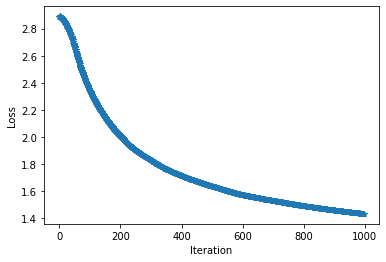

In [99]:
n_hidden = 128
net = RNN(n_letters, n_hidden, n_categories)
train_setup(net, lr=0.0005, n_batches=1000, batch_size = 256)

In [0]:
def evaluate1(net,n_points):
  pred=[]
  true=[]
  a1=dataloader(n_points)
  for name,lang,name_ind,lang_ind in a1:
    ans=infer(net,name)
    
    ind1=ans.detach().numpy()
    ind=np.argmax(ind1)
    pred.append(all_categories[ind])
    true.append(lang)
    #print(all_categories[ind])
    #print(ind)
    """if lang_ind in ind:
      correct+=1
  accuracy=correct/n_points
  return accuracy*100    """
  print(confusion_matrix(pred, true, labels=all_categories))



In [0]:
evaluate1(net,1000)

#batching input

In [0]:
def batched_input(names,maxWordSize):
  inp=torch.zeros(maxWordSize,len(names),n_letters)
  for index, name in enumerate(names):
    for ind,letter in enumerate(name):
      pos=all_letters.find(letter)
      inp[ind][index][pos]=1
  return inp    

In [0]:
def batched_output(lang):
  inp=torch.zeros([len(lang)],dtype=torch.long)
  for i,l in enumerate(lang):
    pos=all_categories.index(l)
    inp[i]=pos
  return inp  

In [0]:
data=dataloader(3)

In [0]:
def find_max(data,n_points):
    #data=dataloader(n_points)
    len1=[]
    max=0
    for name,lang,name_in,lang_in in data:
      a1=len(name)
      len1.append(a1)
      if(a1>max):
        max=a1
    return max,len1     


In [0]:
a3

In [0]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()
        self.hidden_size=hidden_size
        self.rnn1=nn.RNN(input_size,hidden_size)
        #self.iOh=nn.Linear(input_size+hidden_size,hidden_size)
        self.iOo=nn.Linear(hidden_size,output_size)
        self.softmax=nn.LogSoftmax(dim=1)
    def forward(self,input,hidden=None,batch_size=1):
      output,hidden=self.rnn1(input,hidden)   
      output=self.iOo(hidden.view(-1,hidden_size))
      output=self.softmax(output)
      return output,hidden
    def initHidden(self,batch_size=1):
      h1=torch.zeros(1,batch_size,self.hidden_size)
      return h1  

"""   input=N*1*n_letters
      output by RNN is= N*1*hidden_size (for each alphabet of input letter)
      hidden by RNN is= 1*1*hidden_size
      final output after linear transformation= 1*output_size
      and after softmax=1*output_size"""



"""   after Batching   """

"""   input=N*batch_size*n_letters
      output by RNN is= N*batch_size*hidden_size (for each alphabet of input letter)
      hidden by RNN is= 1*batch_size*hidden_size
      final output after linear transformation= batch_size*output_size
      and after softmax=batch_size*output_size"""



In [0]:
rnn=RNN2(n_letters,128,n_categories)

In [0]:
o,h=rnn(a2,batch_size=3)

In [181]:
o.size()

torch.Size([3, 18])

In [182]:
h.size()

torch.Size([1, 3, 128])

In [0]:
data=dataloader(5)

In [0]:
data

#Training batched data

In [0]:
def batched_dataloader(n_points, verbose=False, device = 'cpu'):
    nam=[]
    lang=[]
    
    length=[]
    data=dataloader(n_points)
    #a1,length=find_max(data,n_points)
    
    for name,languages,name_in,lang_in in data:
      nam.append(name)
      lang.append(languages)
      a1=len(name)
      length.append(a1)
    max_length = max(length)  
    a2=batched_input(nam,max_length)
    a3=batched_output(lang)  


    """names = []
    langs = []
    
    
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)"""
    
    """names_rep = batched_name_rep(names, max_length).to(device)
    langs_rep = batched_lang_rep(langs).to(device)"""
    
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(a2, length, enforce_sorted = False)
    
    if verbose:
        print(a2.shape, padded_names_rep.data.shape)
        print('--')
    
    if verbose:
        print(nam)
        #print_char(names_rep)
        print('--')
    
    if verbose:
        #print_char(padded_names_rep.data)
        print('Lang Rep', a3.data)
        print('Batch sizes', padded_names_rep.batch_sizes)
    
    
    return padded_names_rep.to(device), a3


In [0]:
a12,a13=batched_dataloader(5,True)

In [0]:
o,h=rnn(a12,batch_size=5)

In [232]:
o.size()

torch.Size([5, 18])

In [233]:
h.size()

torch.Size([1, 5, 128])

In [0]:
def train_batch(net, opt, criterion, n_points, device = 'cpu'):
    
    net.train().to(device)
    opt.zero_grad()
    
    batch_input, batch_groundtruth = batched_dataloader(n_points, False, device)
    
    output, hidden = net(batch_input)
    
    loss = criterion(output, batch_groundtruth)
    
    loss.backward()
    opt.step()
    return loss

In [0]:

net = RNN2(n_letters, 128, n_categories)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [236]:
train_batch(net,opt,criterion,5)

tensor(2.9351, grad_fn=<NllLossBackward>)

#Final traoining setup

In [0]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    #print('Top-1:', evaluate(net, len(X_test), 1, X_test, y_test, device), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test, device))
    print( 'Top-1:', evaluate(net, 1000), 'Top-2:', evaluate(net,1000))

In [0]:
net = RNN2(n_letters, 128, n_categories)
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=500) 

#LSTM

In [0]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.lstm_cell(input, hidden)
        output = self.h2o(hidden[0].view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return (torch.zeros(1, batch_size, self.hidden_size), torch.zeros(1, batch_size, self.hidden_size))

Iteration 7999 Loss 0.30831626057624817


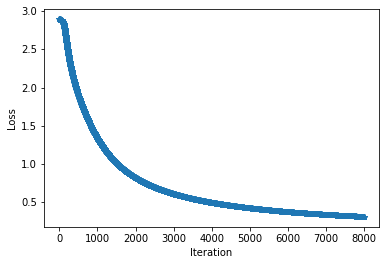

AttributeError: ignored

In [246]:
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_categories)
train_setup(net, lr=0.15, n_batches=8000, batch_size = 512, display_freq=1000)

In [0]:
def infer(net, name, device = 'cpu'):
    name_ohe = name_rep(name).to(device)
    
    output, hidden = net(name_ohe)
        
    if type(hidden) is tuple: # For LSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)
    
    return output